In [33]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from scipy.stats import norm

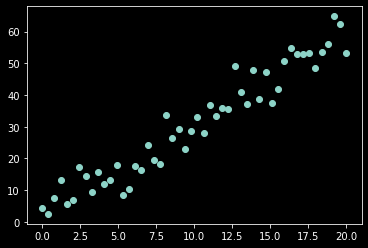

In [34]:
# model: y=ax+b, "find a, b" (linear simple regression, but Bayesian version)
# generate some manually/randomly done data pairs (xi,yi) that you can plot as scatter plot
# define a likelihood for measurement errors, e.g. Gaussian with mean 0 and some measurement error variance (typically smaller than the variance of the y-data)

true_a = 3
true_b = 2
true_meas_stdev = 5
samples = 50

# x-values
x = np.linspace(start=0, stop=20, num=samples)

# y-values <-- ax + b + N(0,stdv)
y =  true_a*x + true_b + np.random.normal(loc=0, scale=true_meas_stdev, size=samples)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x, y, marker='o')
plt.show()

In [35]:
# Check least squares linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(np.matrix(x).T.A, y)
print(f'Least squares:\na: {lr.coef_[0]:.3f}\nb: {lr.intercept_:.3f}')

Least squares:
a: 2.855
b: 2.322


In [36]:
# - define a prior on the parameters a, b (e.g. independent, Gauss, zero mean, large variance so that a and b can take on values that would fit the data)
stdev_a = 5
stdev_b = 5

# - choose a proposal density (e.g. Gaussian, centered on current values, and a stdev found by trial and error*)
stdev_prop = 0.15

In [37]:
# Functions

def prior_a(x):
    return norm.logpdf(x, loc=0, scale=stdev_a)

def prior_b(x):
    return norm.logpdf(x, loc=0, scale=stdev_b)

def new_cand(prev):
    return np.random.normal(loc=prev, scale=stdev_prop)

def calc_posteriors(params, x, y, priors):
    prop_a = params[0]
    prop_b = params[1]
    pred = prop_a * x + prop_b
    single_likelihoods = norm.logpdf(y, loc=pred, scale = true_meas_stdev)
    likelihood = np.sum(single_likelihoods)

    posterior_a = priors[0](prop_a) + likelihood
    posterior_b = priors[1](prop_b) + likelihood

    return posterior_a, posterior_b

def accept_new(posterior_prev, posterior_new, prev, new):
    r = np.exp(posterior_new + norm.logpdf(prev, loc=new, scale=stdev_prop) - posterior_prev - norm.logpdf(new, loc=prev, scale=stdev_prop))
    # print(f'r: ' + str(r))
    if np.random.random() < r:
        return True
    else:
        return False

In [38]:
# - generate samples of a,b conditional on the data with your self-written MCMC

def metropolis_hastings(list_initial_samples, iter):
    num_accepted_a = 0
    num_accepted_b = 0
    
    samples = np.zeros((iter, 4))
    samples[0] = np.array(list_initial_samples)
    
    for i in range(1,iter):
        # new candidates
        new_a = new_cand(samples[i-1,0])
        new_b = new_cand(samples[i-1,1])
        # print(f'New a: {new_a}')
        # print(f'New b: {new_b}')

        # calculate posterior of a and b
        posterior_new_a, posterior_new_b = calc_posteriors([new_a, new_b], x, y, [prior_a, prior_b])
        # print(f'Posterior a: {posterior_a}')
        # print(f'Posterior b: {posterior_b}')

        # write same as previous
        samples[i] = samples[i-1]

        # check new a
        if accept_new(samples[i-1,2], posterior_new_a, samples[i-1,0], new_a):
            samples[i,0] = new_a
            samples[i,2] = posterior_new_a
            num_accepted_a += 1

        # check new b
        if accept_new(samples[i-1,3], posterior_new_b, samples[i-1,1], new_b):
            samples[i,1] = new_b
            samples[i,3] = posterior_new_b
            num_accepted_b += 1

    return samples, num_accepted_a, num_accepted_b

In [39]:
# Initial values
initial_a = 4
initial_b = 1.5

# Initial Posteriors
post_initial_a, post_initial_b = calc_posteriors([initial_a, initial_b], x, y, [prior_a, prior_b])

# Setup first row
initial_samples = [
    initial_a,
    initial_b,
    post_initial_a,
    post_initial_b
    ]

print(initial_samples)

[4, 1.5, -308.31797029596925, -308.0429702959692]


In [40]:
iter = 50000
samples_a_b, accepted_a, accepted_b = metropolis_hastings(initial_samples, iter)
print(
        f'Iterations: {iter}\n\
        Accepted a\'s: {accepted_a}\n\
        Acceptance rate a\'s: {(accepted_a/(iter-1))*100:.2f}%\n\
        Accepted b\'s: {accepted_b}\n\
        Acceptance rate b\'s: {(accepted_b/(iter-1))*100:.2f}%'
        )

Iterations: 50000
        Accepted a's: 21443
        Acceptance rate a's: 42.89%
        Accepted b's: 21459
        Acceptance rate b's: 42.92%


In [41]:
# Set burn in and analyze the data
import pandas as pd
burn_in = int(0.1*iter)
samples = pd.DataFrame(samples_a_b[burn_in:np.shape(samples_a_b)[0], :], columns=['a', 'b', 'post_a', 'post_b'])

In [42]:
print(f'Rows in the original markov chain: {np.shape(samples_a_b)[0]}.')
print(f'Rows in the \"burned\" markov chain: {samples.shape[0]}.')

Rows in the original markov chain: 50000.
Rows in the "burned" markov chain: 45000.


In [43]:
def mode_data(data, num_bins):
    p_hist, bin_hist, _ = plt.hist(data, bins=num_bins)
    plt.close()
    max_count_entry = np.argmax(p_hist)
    return p_hist[max_count_entry], (bin_hist[max_count_entry-1] + bin_hist[max_count_entry])/2

mode_data(samples_a_b[:,0],100)

num_bins = 100
count_a, mode_a = mode_data(samples['a'], num_bins)
count_b, mode_b = mode_data(samples['b'], num_bins)

print(f'MCMC approach:\nMean a: {mode_a:.3f}\nMean b: {mode_b:.3f}')
print(f'\nLeast squares:\na: {lr.coef_[0]:.3f}\nb: {lr.intercept_:.3f}')

MCMC approach:
Mean a: 2.873
Mean b: 2.387

Least squares:
a: 2.855
b: 2.322


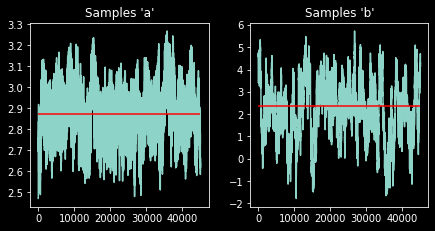

In [44]:
# Plots!
# visualize the history of a,b samples in a 2D "trace plot"
cm = 1/2.54

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15.9*cm, 8*cm))
fig.tight_layout()

# Plot A
axes[0].plot(samples['a'])
axes[0].hlines(mode_a, color='r', xmin=0, xmax=iter-burn_in)
axes[0].set_title('Samples \'a\'')

# Plot B
axes[1].plot(samples['b'])
axes[1].hlines(mode_b, color='r', xmin=0, xmax=iter-burn_in)
axes[1].set_title('Samples \'b\'')

plt.savefig('plots/trace plot.png', dpi=300)
plt.show()

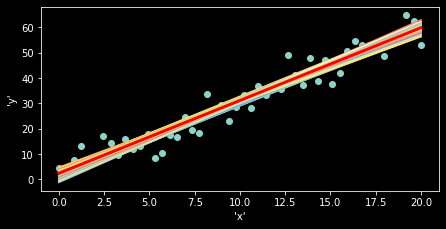

In [45]:
# visualize the results as a set of, e.g., 100 versions of y=ax+b into the scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15.9*cm, 8*cm))
fig.tight_layout()

for i in range(100):
    j = np.random.randint(0, iter-burn_in-1)
    a = samples['a'][j]
    b = samples['b'][j]
    y_conf = a*x + b
    axes.plot(x, y_conf)

y_mean = mode_a*x + mode_b
axes.plot(x, y_mean, color='r', linewidth=3)
axes.scatter(x, y, marker='o')
axes.set_xlabel('\'x\'')
axes.set_ylabel('\'y\'')

plt.savefig('plots/100 plots.png', dpi=300)
plt.show()

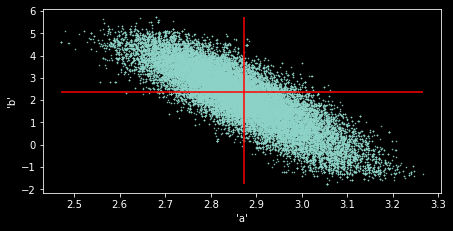

In [46]:
# plot a scatterplot of a,b; histograms of a and of b
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15.9*cm, 8*cm))
fig.tight_layout()
axes.plot(samples['a'], samples['b'], '.', markersize=1)
axes.set_xlabel('\'a\'')
axes.set_ylabel('\'b\'')
axes.hlines(mode_b, color='r', xmin=min(samples['a']), xmax=max(samples['a']))
axes.vlines(mode_a, color='r', ymin=min(samples['b']), ymax=max(samples['b']))
plt.savefig('plots/scatter.png', dpi=300)
plt.show()

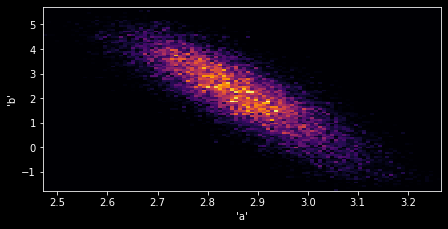

In [47]:
# 2D histogram
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15.9*cm, 8*cm))
fig.tight_layout()
axes.hist2d(samples['a'], samples['b'], bins=num_bins, cmap='inferno')
axes.set_xlabel('\'a\'')
axes.set_ylabel('\'b\'')
plt.savefig('plots/2d_hist.png', dpi=300)
plt.show()

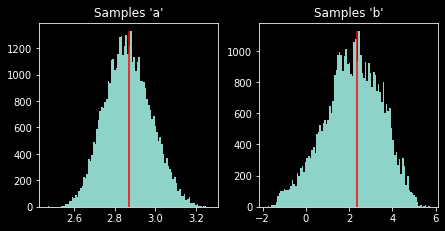

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15.9*cm, 8*cm))
fig.tight_layout()

# Plot A
axes[0].hist(samples['a'], bins=num_bins)
axes[0].vlines(mode_a, color='r', ymin=0, ymax=count_a)
axes[0].set_title('Samples \'a\'')

# Plot B
axes[1].hist(samples['b'], bins=num_bins)
axes[1].vlines(mode_b, color='r', ymin=0, ymax=count_b)
axes[1].set_title('Samples \'b\'')

plt.savefig('plots/histograms.png', dpi=300)
plt.show()

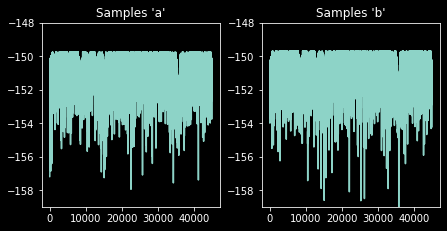

In [49]:
# Plots!
# visualize the history of a,b samples in a 2D "trace plot"
cm = 1/2.54

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15.9*cm, 8*cm))
fig.tight_layout()

# Plot A
axes[0].plot(samples['post_a'])
# axes[0].hlines(mode_a, color='r', xmin=0, xmax=iter)
axes[0].set_ylim([-159,-148])
axes[0].set_title('Samples \'a\'')

# Plot B
axes[1].plot(samples['post_b'])
# axes[1].hlines(mode_b, color='r', xmin=0, xmax=iter)
axes[1].set_ylim([-159,-148])
axes[1].set_title('Samples \'b\'')

plt.savefig('plots/post_trace_plot.png', dpi=300)
plt.show()

In [50]:
# std dev proposal?

iter = 1000
rates_a, rates_b = [], []
test_stdev_proposal = np.linspace(0.01,1,50)

for e in test_stdev_proposal:
    stdev_prop = e
    samples_a_b, accepted_a, accepted_b = metropolis_hastings(initial_samples, iter)
    rates_a.append(accepted_a/(iter-1))
    rates_b.append(accepted_b/(iter-1))


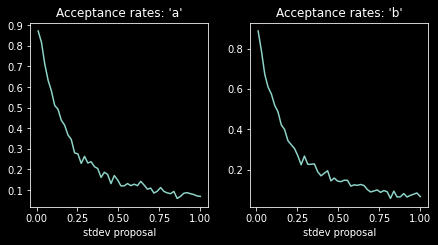

In [51]:
#Plot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15.9*cm, 8*cm))
fig.tight_layout()

# Plot A
axes[0].plot(test_stdev_proposal, rates_a)
axes[0].set_title('Acceptance rates: \'a\'')
axes[0].set_xlabel('stdev proposal')

# Plot B
axes[1].plot(test_stdev_proposal, rates_b)
axes[1].set_title('Acceptance rates: \'b\'')
axes[1].set_xlabel('stdev proposal')

plt.savefig('plots/stdev_acceptance_rates.png', dpi=300)
plt.show()